In [67]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
dnkumars_cybersecurity_intrusion_detection_dataset_path = kagglehub.dataset_download('dnkumars/cybersecurity-intrusion-detection-dataset')

print('Data source import complete.')


Data source import complete.


In [68]:
import numpy as np
import pandas as pd

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier # Model for training
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder,StandardScaler

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/cybersecurity-intrusion-detection-dataset/cybersecurity_intrusion_data.csv


# Working with dataset

In [69]:
# I selected this dataset, because this dataset is big enough for training a model,
# also it created in a way to have some correlations which are going to help me to train a model with good accuracy.

# Read data
df = pd.read_csv('/kaggle/input/cybersecurity-intrusion-detection-dataset/cybersecurity_intrusion_data.csv')
df.head(3)

,session_id,network_packet_size,protocol_type,login_attempts,session_duration,encryption_used,ip_reputation_score,failed_logins,browser_type,unusual_time_access,attack_detected
0,SID_00001,599,TCP,4,492.983263,DES,0.606818,1,Edge,0,1
1,SID_00002,472,TCP,3,1557.996461,DES,0.301569,0,Firefox,0,0
2,SID_00003,629,TCP,3,75.044262,DES,0.739164,2,Chrome,0,1


In [70]:
# Extract info about data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9537 entries, 0 to 9536
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   session_id           9537 non-null   object 
 1   network_packet_size  9537 non-null   int64  
 2   protocol_type        9537 non-null   object 
 3   login_attempts       9537 non-null   int64  
 4   session_duration     9537 non-null   float64
 5   encryption_used      7571 non-null   object 
 6   ip_reputation_score  9537 non-null   float64
 7   failed_logins        9537 non-null   int64  
 8   browser_type         9537 non-null   object 
 9   unusual_time_access  9537 non-null   int64  
 10  attack_detected      9537 non-null   int64  
dtypes: float64(2), int64(5), object(4)
memory usage: 819.7+ KB


In [71]:
# Shape of data
print(f"There are {df.shape[0]}, row and {df.shape[1]} columns in the dataset")

There are 9537, row and 11 columns in the dataset


In [72]:
# Check for missing values in each column
missing_values = df.isnull().sum()
print(missing_values)

session_id                0
network_packet_size       0
protocol_type             0
login_attempts            0
session_duration          0
encryption_used        1966
ip_reputation_score       0
failed_logins             0
browser_type              0
unusual_time_access       0
attack_detected           0
dtype: int64


# Dropping unnecessary columns (also fixing null data problem)

In [73]:
df = df.drop(["session_id","encryption_used"],axis=1)

In [74]:
# Checking the results
df.isnull().sum()

,0
network_packet_size,0
protocol_type,0
login_attempts,0
session_duration,0
ip_reputation_score,0
failed_logins,0
browser_type,0
unusual_time_access,0
attack_detected,0


In [75]:
# Checking duplicate values
df.duplicated().sum()

np.int64(0)

In [76]:
# List rest of the column names
print(df.columns)

Index(['network_packet_size', 'protocol_type', 'login_attempts',
       'session_duration', 'ip_reputation_score', 'failed_logins',
       'browser_type', 'unusual_time_access', 'attack_detected'],
      dtype='object')


# Data exploration, visualization

In [77]:
# Extract info about numerical data
df.describe()

,network_packet_size,login_attempts,session_duration,ip_reputation_score,failed_logins,unusual_time_access,attack_detected
count,9537.000000,9537.000000,9537.000000,9537.000000,9537.000000,9537.000000,9537.000000
mean,500.430639,4.032086,792.745312,0.331338,1.517773,0.149942,0.447101
std,198.379364,1.963012,786.560144,0.177175,1.033988,0.357034,0.497220
min,64.000000,1.000000,0.500000,0.002497,0.000000,0.000000,0.000000
25%,365.000000,3.000000,231.953006,0.191946,1.000000,0.000000,0.000000
50%,499.000000,4.000000,556.277457,0.314778,1.000000,0.000000,0.000000
75%,635.000000,5.000000,1105.380602,0.453388,2.000000,0.000000,1.000000
max,1285.000000,13.000000,7190.392213,0.924299,5.000000,1.000000,1.000000


<ipython-input-78-eb7abc9d8816>:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




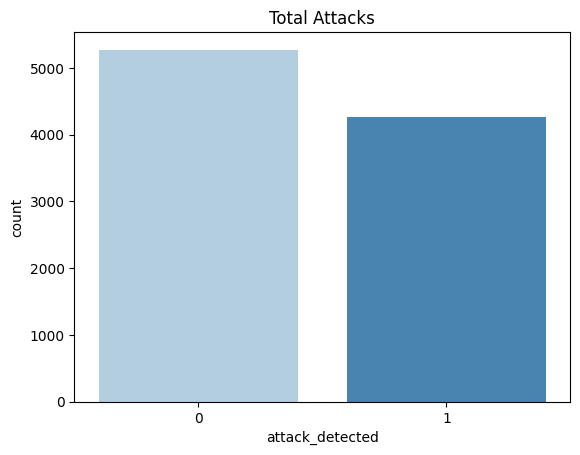

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(x="attack_detected",data=df,palette="Blues")
plt.title("Total Attacks")
plt.show()

In [79]:
import matplotlib.pyplot as plt
import plotly.express as px

# Browser Distribution
plt = px.pie(df, names = 'browser_type', title = 'Browser Distribution')
plt.show()

In [80]:
# Using LaberEncoder to work with text values, it's for generating the heatmap
le=LabelEncoder()
df["protocol_type"]=le.fit_transform(df["protocol_type"])
df["browser_type"] = le.fit_transform(df["browser_type"])

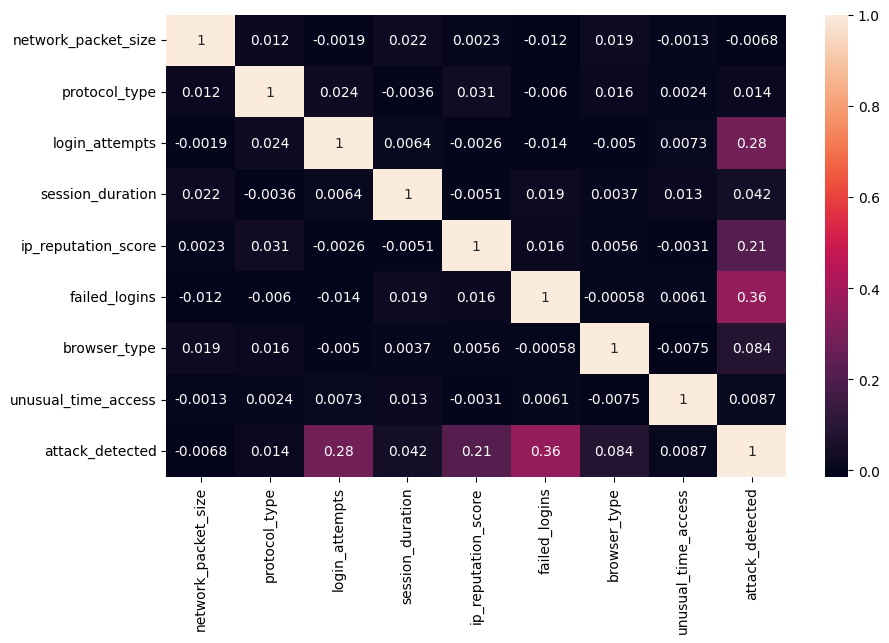

In [81]:
import matplotlib.pyplot as plt

# Using heatmap to see correlations
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(),annot=True)
plt.show()

In [ ]:
# We can see that there are nice amount of correlations

In [82]:
# Seperate categorical and numerical columns, we will encode text based for model training
categorical_cols = df.select_dtypes(include="object").columns.tolist()
numerical_cols = df.select_dtypes(include="int64, float64").columns.tolist()

In [84]:
# Encode categorical columns (One Hot Encoding)
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True, dtype=int)

In [85]:
# We can see that all the data based on numbers now
df.head()

,network_packet_size,protocol_type,login_attempts,session_duration,ip_reputation_score,failed_logins,browser_type,unusual_time_access,attack_detected
0,599,1,4,492.983263,0.606818,1,1,0,1
1,472,1,3,1557.996461,0.301569,0,2,0,0
2,629,1,3,75.044262,0.739164,2,0,0,1
3,804,2,4,601.248835,0.123267,0,4,0,1
4,453,1,5,532.540888,0.054874,1,2,0,0


In [86]:
# Determine features and target, features are input and target is output
y = df['attack_detected']
X = df.drop(columns='attack_detected', axis=1)

In [87]:
# Seperate data to train and test parts, I'm seperating 25% of the data as test, we'll use it later for checking the model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=22)

In [88]:
# Parameter grid for GridSearchCV, this will check different combinations to find best accuracy
param_grid = {
    'n_estimators': [100, 200, 400, 500],
    'max_depth': [3, 5, 10, 20],
    'min_samples_split': [2, 5, 10, 20]
}

In [89]:
# Define model, we're using Random Forest model, which is basic for Classification
rf = RandomForestClassifier(random_state=22)

In [90]:
# Apply GridSearchCV
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

In [91]:
# Fit GridSearchCV
model = grid_search.fit(X_train, y_train)

In [92]:
# We can see the results
print(f"Best parameters: {model.best_params_}")
print(f"Best accuracy score: {model.best_score_}")

Best parameters: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 200}
Best accuracy score: 0.8942942731621976


In [97]:
# Test it with best model
best_model = model.best_estimator_

In [94]:
# Predict outputs, now we're giving our test data that we seperated
predictions = best_model.predict(X_test)

In [95]:
print(f"Test set accuracy score: {accuracy_score(y_test, predictions)}")

Test set accuracy score: 0.8918238993710692


In [96]:
# Cross validation score, creating 10 piles, and we'll get array of accuracies and mean accuracy
cv_scores = cross_val_score(best_model, X_train, y_train, cv=10, scoring='accuracy')
print(f"Cross Validation Scores: {cv_scores}")
print(f"Mean Score: {cv_scores.mean()}")

Cross Validation Scores: [0.90083799 0.90642458 0.8965035  0.89230769 0.88111888 0.88811189
 0.9006993  0.88951049 0.8965035  0.8951049 ]
Mean Score: 0.8947122709692541
